In [22]:
import torch # CUDA 12.6 version used
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [23]:
# Set Device to GPU if Available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Arrange Training, Validation, and Testing Data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

all_training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_size = int(0.9 * len(all_training_data))
validation_size = len(all_training_data) - training_size
training_data, validation_data = random_split(all_training_data, [training_size, validation_size])

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [24]:
# Base Hyperparameters

batch_size = 128
epoch_num = 25
patience = 3
learning_rate = 0.001

In [25]:
# Base Model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model_t1 = CNN()
model_t1.to(device)
crit_t1 = nn.CrossEntropyLoss()
opt_t1 = optim.Adam(model_t1.parameters(), lr=learning_rate)


In [26]:
# Task 1 Model Training and Validation

max_validation_loss = float('inf')
stop_count = 0
training_loss_values = []
validation_loss_values = []

for epoch in range(epoch_num):
    model_t1.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t1.zero_grad()
        outputs = model_t1(inputs)
        loss = crit_t1(outputs, labels)
        loss.backward()
        opt_t1.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values.append(training_loss)
            
    model_t1.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t1(validation_inputs)
            validation_loss += crit_t1(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")
    
    if validation_loss < max_validation_loss:
        max_validation_loss = validation_loss
        torch.save(model_t1.state_dict(), "cnn_model.pth")
        stop_counter = 0
    else:
        stop_counter += 1
        if stop_counter >= patience:
            break

print("done")

Epoch 1: Training Loss = 1.721, Validation Loss = 1.468
Epoch 2: Training Loss = 1.384, Validation Loss = 1.335
Epoch 3: Training Loss = 1.234, Validation Loss = 1.185
Epoch 4: Training Loss = 1.126, Validation Loss = 1.094
Epoch 5: Training Loss = 1.046, Validation Loss = 0.998
Epoch 6: Training Loss = 0.973, Validation Loss = 0.992
Epoch 7: Training Loss = 0.919, Validation Loss = 0.952
Epoch 8: Training Loss = 0.862, Validation Loss = 0.915
Epoch 9: Training Loss = 0.811, Validation Loss = 0.879
Epoch 10: Training Loss = 0.768, Validation Loss = 0.892
Epoch 11: Training Loss = 0.739, Validation Loss = 0.876
Epoch 12: Training Loss = 0.701, Validation Loss = 0.846
Epoch 13: Training Loss = 0.670, Validation Loss = 0.849
Epoch 14: Training Loss = 0.638, Validation Loss = 0.831
Epoch 15: Training Loss = 0.619, Validation Loss = 0.860
Epoch 16: Training Loss = 0.589, Validation Loss = 0.845
Epoch 17: Training Loss = 0.573, Validation Loss = 0.847
done


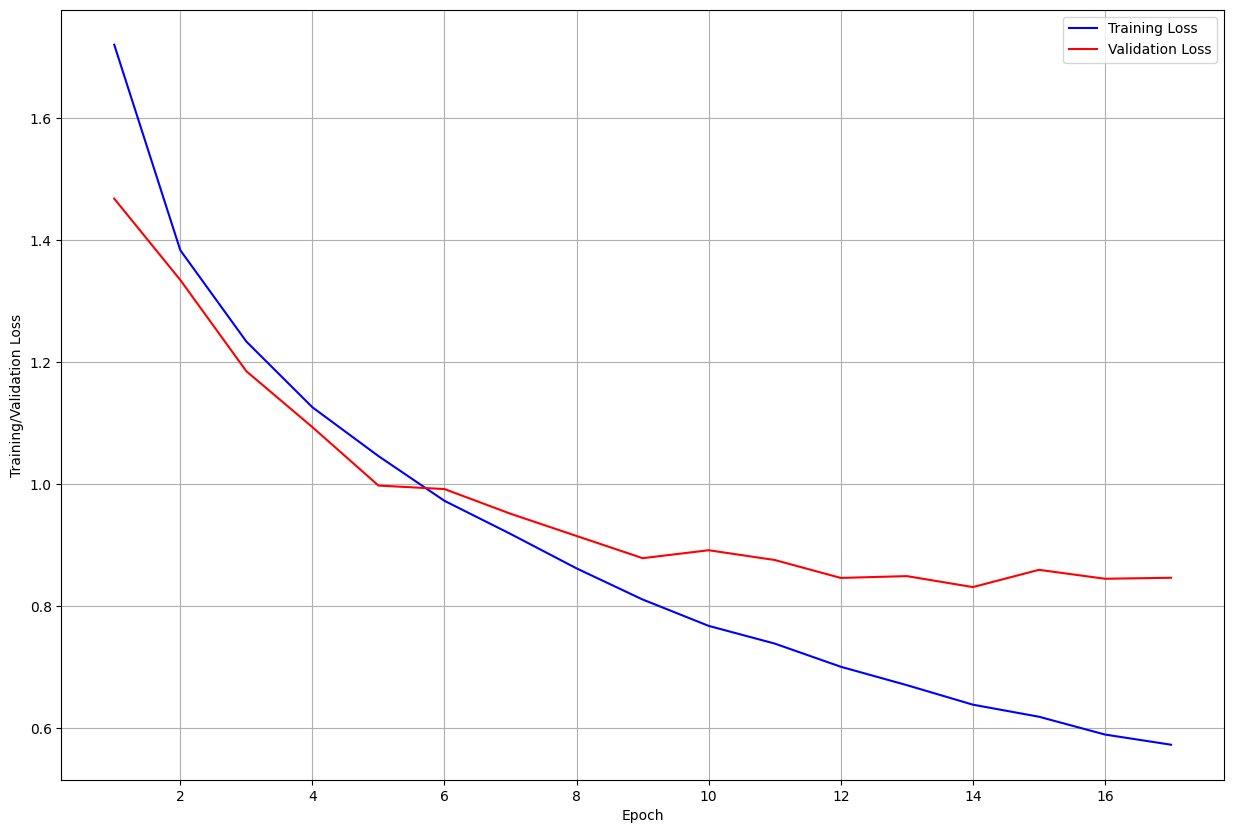

In [27]:
# Task 1 Convergence Graph

x_vals = list(range(1, epoch+2))
plt.figure(figsize=(15,10))
plt.plot(x_vals, training_loss_values, color='b', label='Training Loss')
plt.plot(x_vals, validation_loss_values, color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Training/Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
# Task 2 New Hyperparameters

L2_penalty = 0.0001
dropout = 0.5

In [29]:
# Task 2 Model

class CNNRegularisationDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.dropout = nn.Dropout(p=dropout)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
model_t2 = CNNRegularisationDropout()
model_t2.to(device)
crit_t2 = nn.CrossEntropyLoss()
opt_t2 = optim.Adam(model_t2.parameters(), lr=learning_rate)

In [30]:
# Task 2 Model Training and Validation (with regularisation)

max_validation_loss = float('inf')
stop_count = 0
training_loss_values = []
validation_loss_values = []
final_epoch = 0

for epoch in range(epoch_num):
    model_t2.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2.zero_grad()
        outputs = model_t2(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values.append(training_loss)
            
    model_t2.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.724, Validation Loss = 1.489
Epoch 2: Training Loss = 1.373, Validation Loss = 1.280
Epoch 3: Training Loss = 1.223, Validation Loss = 1.212
Epoch 4: Training Loss = 1.120, Validation Loss = 1.085
Epoch 5: Training Loss = 1.041, Validation Loss = 1.036
Epoch 6: Training Loss = 0.973, Validation Loss = 0.988
Epoch 7: Training Loss = 0.913, Validation Loss = 0.954
Epoch 8: Training Loss = 0.861, Validation Loss = 0.900
Epoch 9: Training Loss = 0.820, Validation Loss = 0.903
Epoch 10: Training Loss = 0.773, Validation Loss = 0.853
Epoch 11: Training Loss = 0.734, Validation Loss = 0.861
Epoch 12: Training Loss = 0.699, Validation Loss = 0.816
Epoch 13: Training Loss = 0.669, Validation Loss = 0.844
Epoch 14: Training Loss = 0.642, Validation Loss = 0.822
Epoch 15: Training Loss = 0.608, Validation Loss = 0.905
Epoch 16: Training Loss = 0.589, Validation Loss = 0.822
Epoch 17: Training Loss = 0.566, Validation Loss = 0.868
Epoch 18: Training Loss = 0.548, Validat